# Minigrid environment

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
from gym_minigrid import minigrid_env
import numpy as np
import cv2
import random
import seaborn as sns
sns.set_theme(style="darkgrid")

pygame 2.5.1 (SDL 2.28.2, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
%load_ext autoreload

In [16]:
env = minigrid_env.Env(size=15, agent_view_size=5, num_tiles=40, training=False)
observation, info = env.reset(seed=42)

In [11]:
%autoreload 2

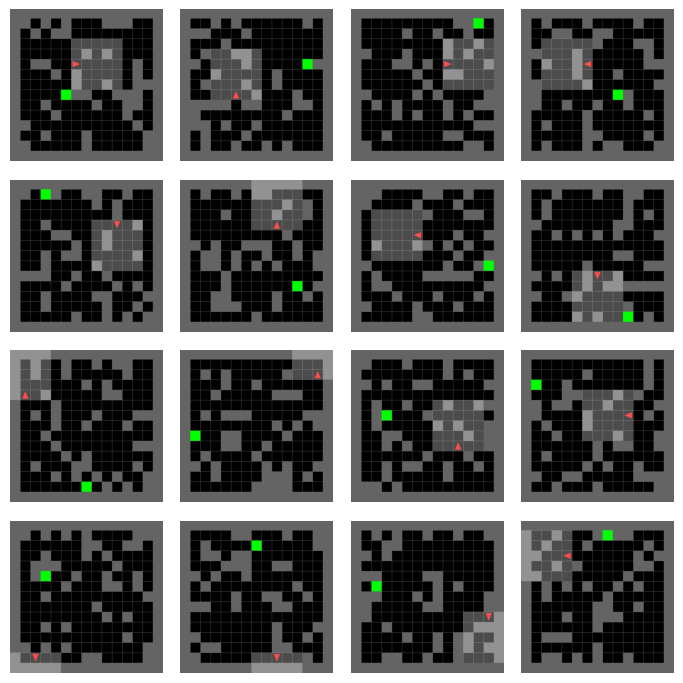

In [17]:
plt.figure(figsize=(7,7))

# Draw 16 environments
for i in range(16):
    plt.subplot(4, 4, i+1)
    _ = env.reset(seed=i)
    plt.imshow(env.get_frame())
    plt.axis('off')

plt.tight_layout()
plt.show()

Path finding algorithm

In [13]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

def get_shortest_path(grid, pos):
    """Get the shortest path from the start to the end

    Args:
    grid (np.array): 2D grid where 0 is free space and 1 is obstacle
    pos (tuple): Start and end position in the grid (start_x, start_y, end_x, end_y)
    """
    pos = np.copy(pos)
    pos = np.clip(pos, 1, grid.shape[0] - 2)
    start, end = pos[:2], pos[2:]
    maze = np.abs(grid - 1)

    # Ensure start and end are free
    maze[start[0], start[1]] = 1
    maze[end[0], end[1]] = 1
    
    grid = Grid(matrix=maze)
    start = grid.node(start[0], start[1])
    end = grid.node(end[0], end[1])
    
    finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
    path, runs = finder.find_path(start, end, grid)

    return path

Generate random grids

In [ ]:
grids = []
pos = []
path_lengths = []
num_grids = 50_000

# Generate a bunch of random grids
for i in range(num_grids):
    env.reset(seed=i)
    grid = env.get_full_render(highlight=False, tile_size=1)
    grids.append(grid)
    positions = np.ravel((env.agent_pos, env.goal_pos))
    pos.append(positions)

    maze = np.ceil(grid/255).mean(axis=-1).astype(int)
    maze[positions[1], positions[0]] = 0
    maze[positions[3], positions[2]] = 0

    path = get_shortest_path(maze, positions)
    path_lengths.append(len(path))

    print(f"Generated {i+1}/{num_grids} grids", end="\r")

grids = np.array(grids)
pos = np.array(pos)
path_lengths = np.array(path_lengths)

Text(0, 0.5, 'Frequency')

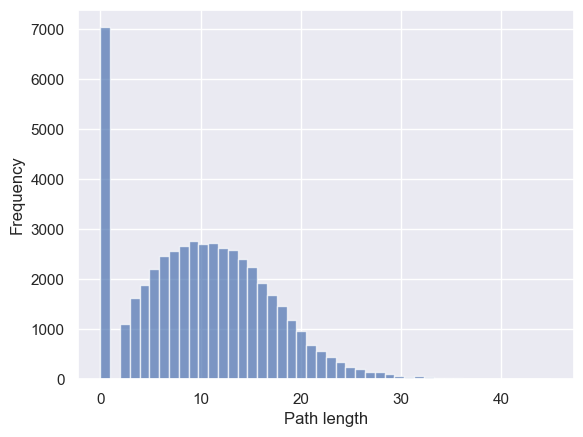

In [35]:
# Plot path length distribution
hist = plt.hist(path_lengths, bins=46, alpha=0.7)
plt.xlabel("Path length")
plt.ylabel("Frequency")

Generate dataset with uniform distribution of path lengths

In [8]:
# Create 10 bins of path lengths from 1 to 30
num_bins = 10
bins = np.linspace(2, 27, num_bins+1)
bins[-1] = 100  # Set last limit to a big number
bins

array([  2. ,   4.5,   7. ,   9.5,  12. ,  14.5,  17. ,  19.5,  22. ,
        24.5, 100. ])

In [170]:
%autoreload 2

In [18]:
grids = []
pos = []
path_lengths = []
NUM_GRIDS = 200_000

NUM_GRIDS_PER_BIN = NUM_GRIDS // num_bins

# Generate a bunch of random grids
for i in range(num_bins):
    for j in range(NUM_GRIDS_PER_BIN):

        path_length = -1
        k = 0
        while (path_length < bins[i] or path_length > bins[i+1]):

            env.reset(seed=i)
            grid = env.get_full_render(highlight=False, tile_size=1)
            positions = np.ravel((env.agent_pos, env.goal_pos))

            maze = np.ceil(grid/255).mean(axis=-1).astype(int)
            maze[positions[1], positions[0]] = 0
            maze[positions[3], positions[2]] = 0

            path_length = len(get_shortest_path(maze, positions))
            k += 1
            
        print(f"Generating bin {i+1}/{num_bins}, {j+1}/{NUM_GRIDS_PER_BIN} grids", end="\r")
        grids.append(grid)
        pos.append(positions)
        path_lengths.append(path_length)            

grids = np.array(grids)
pos = np.array(pos)
path_lengths = np.array(path_lengths)  # 128m 30s 708    135m 30s 1861

(0.0, 43.0)

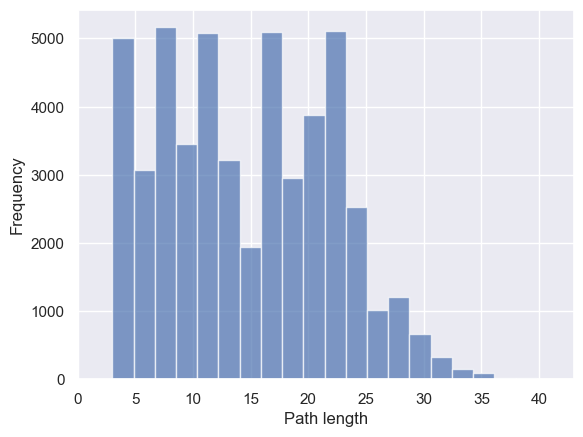

In [177]:
# Plot path length distribution
hist = plt.hist(path_lengths, bins=25, alpha=0.7)
plt.xlabel("Path length")
plt.ylabel("Frequency")

plt.xlim(0,43)

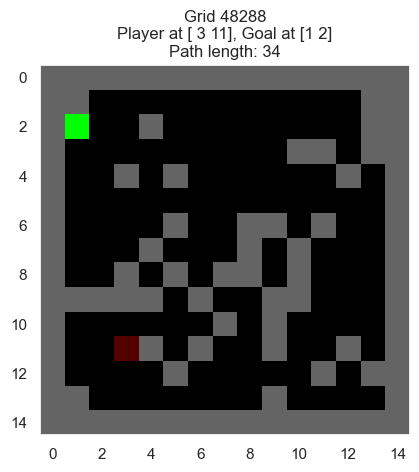

In [201]:
i = random.randint(0, grids.shape[0]-1)
i = 48288

plt.imshow(grids[i])
plt.title(f"Grid {i}\nPlayer at {pos[i][:2]}, Goal at {pos[i][2:]}\nPath length: {path_lengths[i]}")
plt.grid(False)
plt.show()

_______

Create dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class GridsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, grids, pos, img=None):
        self.grids = grids
        self.pos = pos
        self.img = img

    def __len__(self):
        return len(self.grids)

    def __getitem__(self, index):
        x = TF.to_tensor(self.grids[index])
        y = torch.tensor(self.pos[index])
        if self.img is not None:
            img = TF.to_tensor(self.img[index])
            return x, y, img
        return x, y

In [229]:
X = grids
Y = np.array(pos).astype(np.int16)

In [ ]:
# Save the data
np.save("grids_50k_40-blocks.npy", X)
np.save("pos_50k_40-blocks.npy", Y)
np.save("path_lengths_50k_40-blocks.npy", path_lengths)

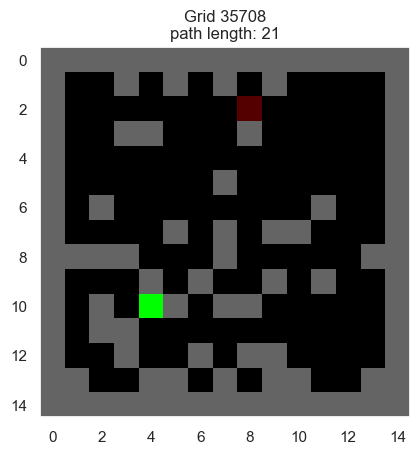

array([ 8,  2,  4, 10], dtype=int16)

In [233]:
i = random.randint(0, len(X)-1)
path_length = path_lengths[i]
plt.imshow(X[i])
plt.title(f"Grid {i}\npath length: {path_length}")
plt.grid(False)
plt.show()

In [8]:
# Load the data
X = np.load("grids_50k_40-blocks.npy")
Y = np.load("pos_50k_40-blocks.npy")
path_lengths = np.load("path_lengths_50k_40-blocks.npy")

# Remove outer walls
X = X[:, 1:-1, 1:-1, :]
Y = Y - 1

In [9]:
X.shape, Y.shape, path_lengths.shape

((50000, 13, 13, 3), (50000, 4), (50000,))

Text(0.5, 1.0, '45685')

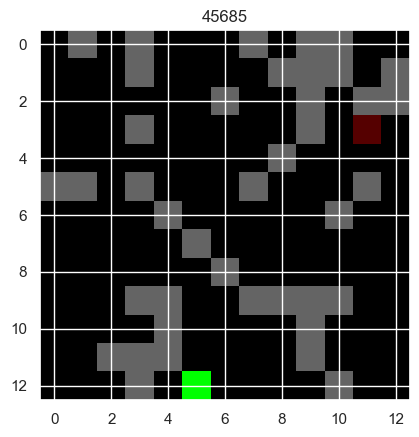

In [54]:
i = random.randint(0, len(X)-1)
plt.imshow(X[i])
plt.title(i)

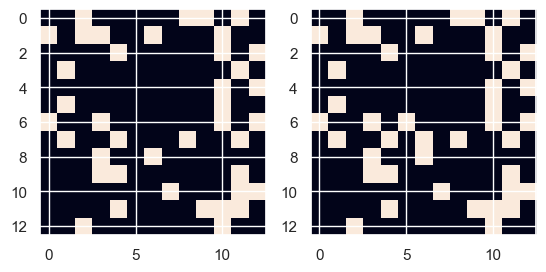

In [44]:
plt.subplot(121)
plt.imshow(maze)

plt.subplot(122)
plt.imshow(maze_)

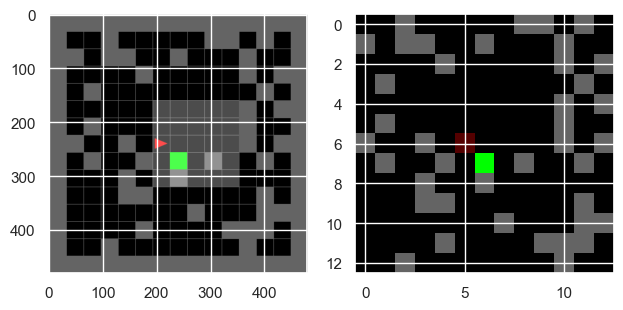

In [46]:
i = 3967

# Get maze and player/goal positions
maze = X[i].mean(axis=-1)
maze[maze > 0] = 1
maze[Y[i][1], Y[i][0]] = 0
maze[Y[i][3], Y[i][2]] = 0
player_pos = Y[i][:2] + 1  # +1 to account for the removed outer walls
goal_pos = Y[i][2:] + 1  # +1 to account for the removed outer walls

# Set maze and positions
env.bit_map = maze
env.agent_start_pos = player_pos
env.goal_pos = goal_pos
_ = env.reset()

plt.subplot(121)
plt.imshow(env.get_frame())

plt.subplot(122)
plt.imshow(X[i])

plt.tight_layout()

In [10]:
num_blocks = 40

idx = 0
points = []

for idx in range(X.shape[0]):

    # Make all pixels with blocks blue
    idxs = np.where(X[idx].mean(axis=-1) == 100)
    X[idx, idxs[0], idxs[1], :] = [0, 0, 255]

    # Make player red and goal green
    X[idx, Y[idx, 1], Y[idx, 0], :] = [255, 0, 0]
    X[idx, Y[idx, 3], Y[idx, 2], :] = [0, 255, 0]

    # Extract coordinates of blocks (blue pixels)
    x, y = np.where(X[idx][:,:,-1] == 255)
    points_ = np.array(list(zip(x, y)))
    # Add player and goal to the points
    points_ = np.concatenate([points_, Y[idx].reshape(-1, 2)])
    points.append(points_)

    if points_.shape[0] != num_blocks + 2:
        print(idx, points_.shape)
        break

    print(f"Processed {idx+1}/{X.shape[0]} grids", end="\r")

points = np.array(points)

In [12]:
X_img = np.copy(X) / 255.
X_img = X_img.astype(np.float32)
X = points.astype(np.float32)
Y = path_lengths.astype(np.float32)

In [13]:
X_img.shape, X.shape, Y.shape

((50000, 13, 13, 3), (50000, 42, 2), (50000,))

In [14]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Create datasets
train_dataset = GridsDataset(X_train, Y_train)
val_dataset = GridsDataset(X_val, Y_val)

In [15]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val, X_img_train, X_img_val, = train_test_split(X, Y, X_img, test_size=0.1, random_state=42)

# Create datasets
train_dataset = GridsDataset(X_train, Y_train, X_img_train)
val_dataset = GridsDataset(X_val, Y_val, X_img_val)

Train model

In [16]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

from VAE import VAE_conv

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
import torch
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=128):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, image_channels=3, output_dim=None):
        super(VAE, self).__init__()

        if output_dim is None:
            output_dim = input_dim - 1
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=False),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim * 2, bias=False)  # Two outputs for mean and variance
        )

        # # Test: Convolutional encoder
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(image_channels + 1, 24, kernel_size=7, stride=1),  # Add conditional input
        #     nn.ReLU(),
        #     nn.Conv2d(24, 32, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 96, kernel_size=1, stride=1),
        #     nn.ReLU(),
        #     Flatten(),
        # )
        # self.fc_mu = nn.Linear(864, latent_dim, bias=False)
        # self.fc_logvar = nn.Linear(864, latent_dim, bias=False)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim//2, bias=False),  # Add conditional input
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim, bias=False),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),  # Remove conditional input
        )

        # # Test: Convolutional decoder
        # self.fc_decoder = nn.Linear(latent_dim + 1, hidden_dim)  # Add conditional input
        
        # self.decoder = nn.Sequential(
        #     UnFlatten(),
        #     nn.ConvTranspose2d(hidden_dim, 48, kernel_size=7, stride=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(48, 32, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 24, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(24, image_channels, kernel_size=3, stride=1),
        #     nn.Sigmoid(),
        # )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x, y):
        # # Convolutional VAE
        # y_ = y.clone().to(device)
        # y = y.reshape((y.shape[0],1,1,1))
        # y = torch.ones(x.shape[0],1,x.shape[2],x.shape[3]).to(device)*y
        # t = torch.cat((x,y),dim=1)

        # # Encode
        # z_params = self.encoder(t)
        # mu = self.fc_mu(z_params)
        # logvar = self.fc_logvar(z_params)
        # z = self.reparameterize(mu, logvar)
        # # Concatenate the last element of x with z
        # z = torch.cat([z, y_], dim=-1)

        # # Convolutional decoder
        # z = self.fc_decoder(z)  # vector output
        # x_hat = self.decoder(z)  # image output

        # Linear VAE
        t = torch.cat((x, y), dim=-1)
        # Encode
        z_params = self.encoder(t)
        mu = z_params[:, :latent_dim]
        logvar = z_params[:, latent_dim:]
        z = self.reparameterize(mu, logvar)

        # Concatenate z and y
        z = torch.cat([z, y], dim=-1)
        
        # Linear decoder
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [41]:
# Loss function
def loss_function(x_hat, x, mu, logvar):

    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_divergence

# For image outputs
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    BCE = F.mse_loss(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [127]:
def train_vae(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, early_stopping={'patience': 5, 'min_delta': 0.001}):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True, min_lr=1e-6)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for x, y, x_img in train_loader:
            optimizer.zero_grad()

            # Flatten the input data if it's not already flattened
            x = x.view(x.size(0), -1)
            x = x.to(device)

            y = y.view(y.size(0), -1)
            y = y.to(device)/30.  # Normalize y

            x_img = x_img.to(device)

            x_hat, mu, logvar = model(x_img, y)
            loss = loss_function(x_hat, x_img, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y, x_img in val_loader:
                x = x.view(x.size(0), -1)
                x = x.to(device)

                y = y.view(y.size(0), -1)
                y = y.to(device)/30.  # Normalize y

                x_img = x_img.to(device)

                x_hat, mu, logvar = model(x_img, y)
                loss = loss_function(x_hat, x_img, mu, logvar)

                val_loss += loss.item()
        val_loss /= len(val_loader.dataset)

        average_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {average_loss:.4f}, val_loss: {val_loss:.4f}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break
            
        scheduler.step(val_loss)

    print('Training finished.')

    return loss_history

In [128]:
# Number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [129]:
class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)

In [130]:
class VAE_conv(nn.Module):
    def __init__(self, image_channels=1, h_dim=768, z_dim=32):
        super(VAE_conv, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels + 1, 8, kernel_size=3, stride=1),  # Add conditional input
            nn.ReLU(),
            # Pooling layer
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Conv2d(8, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(64*4, z_dim)
        self.fc2 = nn.Linear(64*4, z_dim)
        self.fc3 = nn.Linear(z_dim + 1, h_dim)  # Add conditional input
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=5, stride=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, y):
        y = y.reshape((y.shape[0],1,1,1)).to(device)
        y = torch.ones(x.shape[0],1,x.shape[2],x.shape[3]).to(device)*y
        t = torch.cat((x,y),dim=1)
        h = self.encoder(t)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x, y):
        z, mu, logvar = self.encode(x, y)
        y = y.to(device)
        z = torch.cat((z,y),dim=1)
        z = self.decode(z)
        return z, mu, logvar

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

input_dim = (40 + 2)*2 + 1  # (25 blocks + 1 player position + 1 goal position) + 1 complexity
hidden_dim = 256
latent_dim = 64
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device)
vae_model = VAE_conv(image_channels=3, h_dim=hidden_dim, z_dim=latent_dim).to(device)

print(vae_model)
print(f'The model has {count_parameters(vae_model):,} trainable parameters')

Device: cuda
VAE_conv(
  (encoder): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Flatten()
  )
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=65, out_features=256, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 

In [132]:
batch_size = 32
num_epochs = 2_000
early_stopping = {'patience': 15, 'min_delta': 0.05}

# Data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train VAE
loss_history = train_vae(vae_model,
                        train_loader,
                        val_loader,
                        num_epochs=num_epochs,
                        learning_rate=1e-3,
                        early_stopping=early_stopping)

Epoch [1/2000], train_loss: 34.2806, val_loss: 32.6553
Epoch [2/2000], train_loss: 32.1596, val_loss: 31.0203
Epoch [3/2000], train_loss: 29.7144, val_loss: 28.4033
Epoch [4/2000], train_loss: 27.4812, val_loss: 27.0960
Epoch [5/2000], train_loss: 26.5470, val_loss: 26.2789
Epoch [6/2000], train_loss: 25.8759, val_loss: 25.8651
Epoch [7/2000], train_loss: 25.4343, val_loss: 25.3697
Epoch [8/2000], train_loss: 25.0952, val_loss: 25.1171
Epoch [9/2000], train_loss: 24.7687, val_loss: 24.6333
Epoch [10/2000], train_loss: 24.4459, val_loss: 24.6354
Epoch [11/2000], train_loss: 24.0872, val_loss: 24.1533
Epoch [12/2000], train_loss: 23.8266, val_loss: 23.8338
Epoch [13/2000], train_loss: 23.6633, val_loss: 23.8078
Epoch [14/2000], train_loss: 23.5199, val_loss: 23.5833
Epoch [15/2000], train_loss: 23.3806, val_loss: 23.5623
Epoch [16/2000], train_loss: 23.2221, val_loss: 23.2737
Epoch [17/2000], train_loss: 23.0580, val_loss: 23.1389
Epoch [18/2000], train_loss: 22.9530, val_loss: 23.1386
E

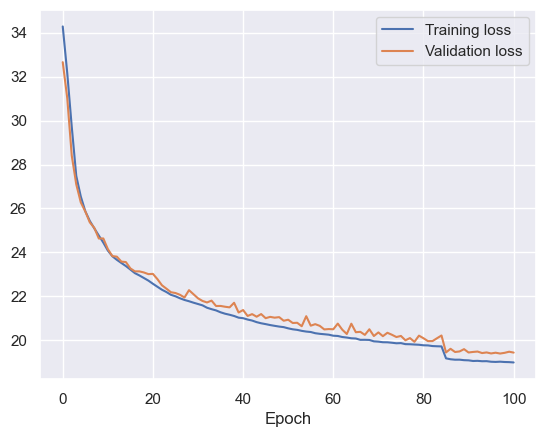

In [133]:
# Plot training and validation loss
plt.plot(loss_history['train_loss'], label="Training loss")
plt.plot(loss_history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.legend()
# plt.ylim(20,50)

In [113]:
# Save VAE model
torch.save(vae_model.state_dict(), f"models/VAE_MiniGrid_latent-dim-{latent_dim}_25-blocks.pt")

In [134]:
# input_dim = (25 + 2)*2 + 1  # (25 blocks + 1 player position + 1 goal position) + 1 complexity
# hidden_dim = 128
# latent_dim = 32
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load VAE model
# vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device) # GPU
# vae_model.load_state_dict(torch.load(f"models/VAE_MiniGrid_latent-dim-{latent_dim}_25-blocks.pt"))
vae_model.eval()

VAE_conv(
  (encoder): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): Flatten()
  )
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=65, out_features=256, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): 

Plot reconstructed grids

In [135]:
# Generate a 15x15 image from 1D vector
def generate_grid_image(points_, start_goal=True):

    points = np.copy(points_)
    points = np.clip(points, 0, 13)
    points += 1  # Because of outer walls

    points[-2:] = np.clip(points[-2:], 1, 13)  # Player and goal

    img = np.zeros((15, 15, 3), dtype=np.uint8)

    # Outer walls
    img[0, :] = 125
    img[-1, :] = 125
    img[:, 0] = 125
    img[:, -1] = 125

    # Blocks
    for x, y in points[:-2]:
        img[y, x] = 125

    if start_goal:
        # Player
        img[points[-2, 1], points[-2, 0], :] = [255, 0, 0]
        # Goal
        img[points[-1, 1], points[-1, 0], :] = [0, 255, 0]

    return img

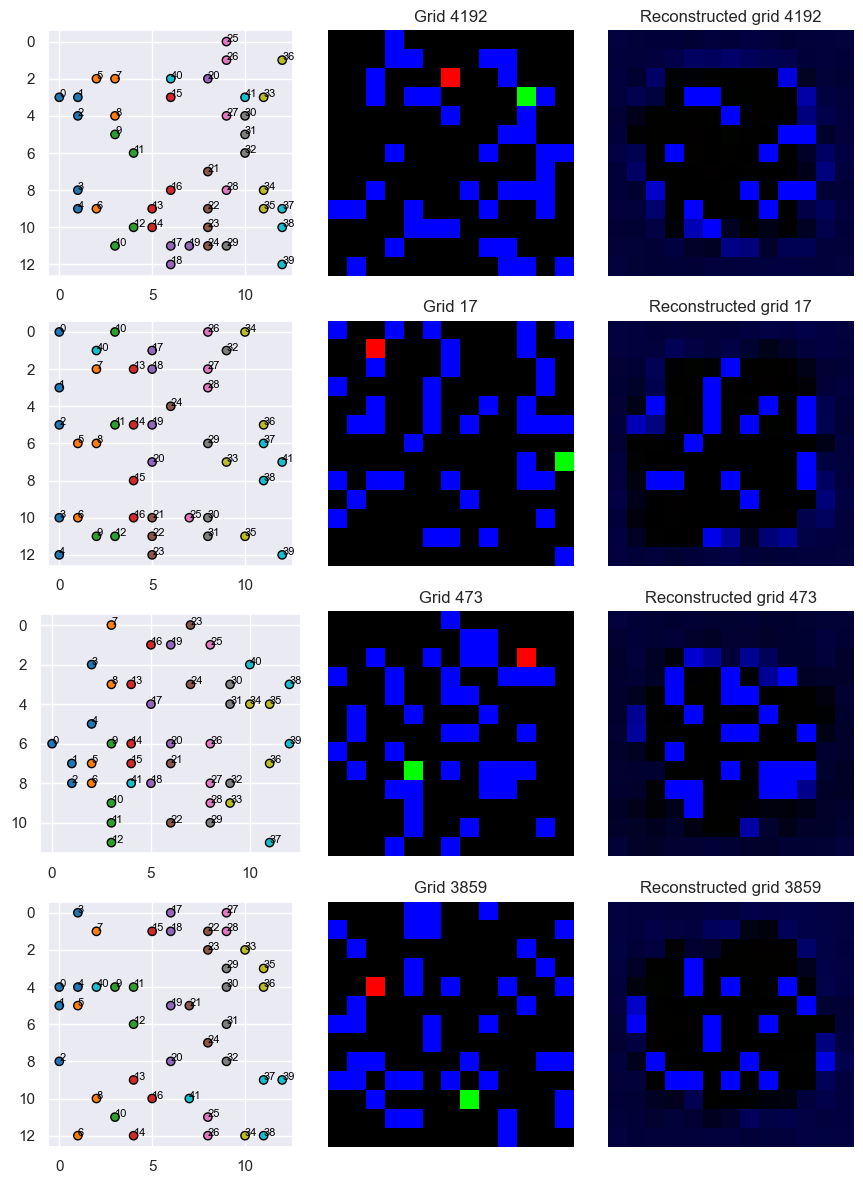

In [142]:
n_images = 4

plt.figure(figsize=(9, int(n_images*3)))

for i in range(n_images):
    j = np.random.randint(0, X_val.shape[0])
    x = val_dataset[j][0]
    y = val_dataset[j][1]
    x = x.view(1, -1).to(device)
    y = y.view(1, -1).to(device) / 30.  # Normalize y
    x_img = val_dataset[j][2].view(1, 3, 13, 13).to(device)
    recon_x, mu, logvar = vae_model.to(device)(x_img,y)

    x = x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
    #recon_x = recon_x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)

    # Plot original and reconstructed points
    plt.subplot(n_images,3,1+3*i)
    
    plt.scatter(x[:,0], x[:,1], cmap="tab10", c=range(x.shape[0]), edgecolor="black")
    #plt.scatter(recon_x[:,0], recon_x[:,1], cmap="tab10", alpha=0.3, c=range(x.shape[0]), edgecolor="gray")
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')

    # Plot number for every point
    for p in range(x.shape[0]):
        plt.text(x[p,0], x[p,1], str(p), fontsize=8, color="black")

    # Plot original grid
    plt.subplot(n_images,3,1+3*i+1)
    #plt.imshow(generate_grid_image(x))
    plt.imshow(x_img.cpu().detach().numpy().squeeze().transpose(1,2,0))
    plt.grid()
    plt.axis('off')
    plt.title(f"Grid {j}")

    # Plot reconstructed grid
    plt.subplot(n_images,3,1+3*i+2)
    #plt.imshow(generate_grid_image(recon_x))
    plt.imshow(recon_x.cpu().detach().numpy().squeeze().transpose(1,2,0))
    plt.grid()
    plt.axis('off')
    plt.title(f"Reconstructed grid {j}")

plt.tight_layout()

In [62]:
# Encode X
XY = torch.cat([torch.tensor(X).view(-1, input_dim-1).float(), torch.tensor(Y).view(-1, 1).float()], dim=-1).to(device)
z_params = vae_model.encoder(XY)
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
z = vae_model.reparameterize(mu, logvar).to('cpu').detach().numpy()

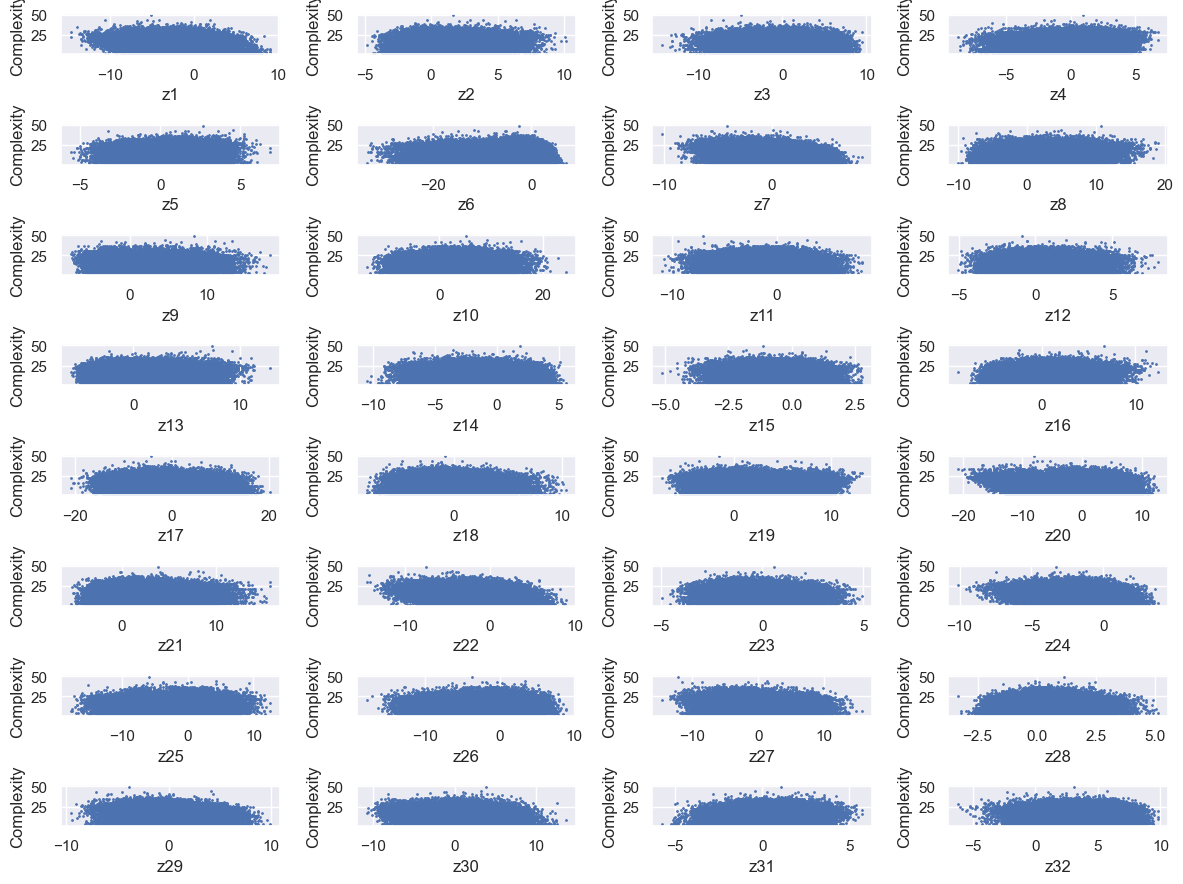

In [65]:
# Plot latent variables against complexity
plt.figure(figsize=(12,9))

for i in range(latent_dim):
    plt.subplot(8, 4, i+1)
    plt.scatter(z[:,i], Y, s=1)
    plt.xlabel(f"z{i+1}")
    plt.ylabel("Complexity")
plt.tight_layout()

In [ ]:
idx = random.randint(0, len(X)-1)
idx = i

maze = np.ceil(X[idx]/255).mean(axis=-1).astype(int)
positions = np.round(Y[idx]*7 + 7).astype(int)
maze[positions[1], positions[0]] = 0
maze[positions[3], positions[2]] = 0

path = get_shortest_path(maze, positions)
path = [(p.y, p.x) for p in path]

In [120]:
# Replace start and end
maze = (np.stack([maze]*3, axis=-1) * 125).astype(np.int16)
maze[positions[1], positions[0]] = [255, 0, 0]
maze[positions[3], positions[2]] = [0, 255, 0]

plt.subplot(121)
plt.imshow(maze)
plt.grid(False)
plt.axis('off')

plt.subplot(122)
# Replace path
for p in path[1:-1]:
    maze[p[0], p[1]] = [0, 0, 255]

plt.imshow(maze)
plt.grid(False)
plt.axis('off')

print("Path length:", len(path))

IndexError: invalid index to scalar variable.

Calculate path length of all grids

In [582]:
path_lengths = []

for i in range(X.shape[0]):
    maze = np.ceil(X[i]/255).mean(axis=-1).astype(int)
    positions = np.round(Y[i]*7 + 7).astype(int)
    maze[positions[1], positions[0]] = 0
    maze[positions[3], positions[2]] = 0

    path = get_shortest_path(maze, positions)

    path_lengths.append(len(path))
    
    print(f"Processed {i+1}/{X.shape[0]}", end="\r")

path_lengths = np.array(path_lengths)

In [594]:
np.save("path_lengths.npy", path_lengths)

In [514]:
zero_length_idxs = np.where(path_lengths == 0)[0]

Text(0.5, 1.0, 'Grid 25182')

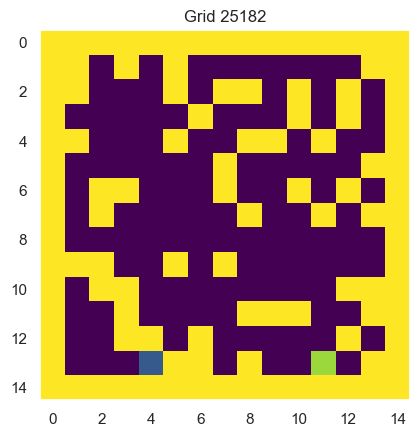

In [517]:
idx = np.random.choice(zero_length_idxs)

plt.imshow(X[idx, ..., 0], cmap='viridis')
plt.grid(False)
plt.title(f"Grid {idx}")

Analyze latent space

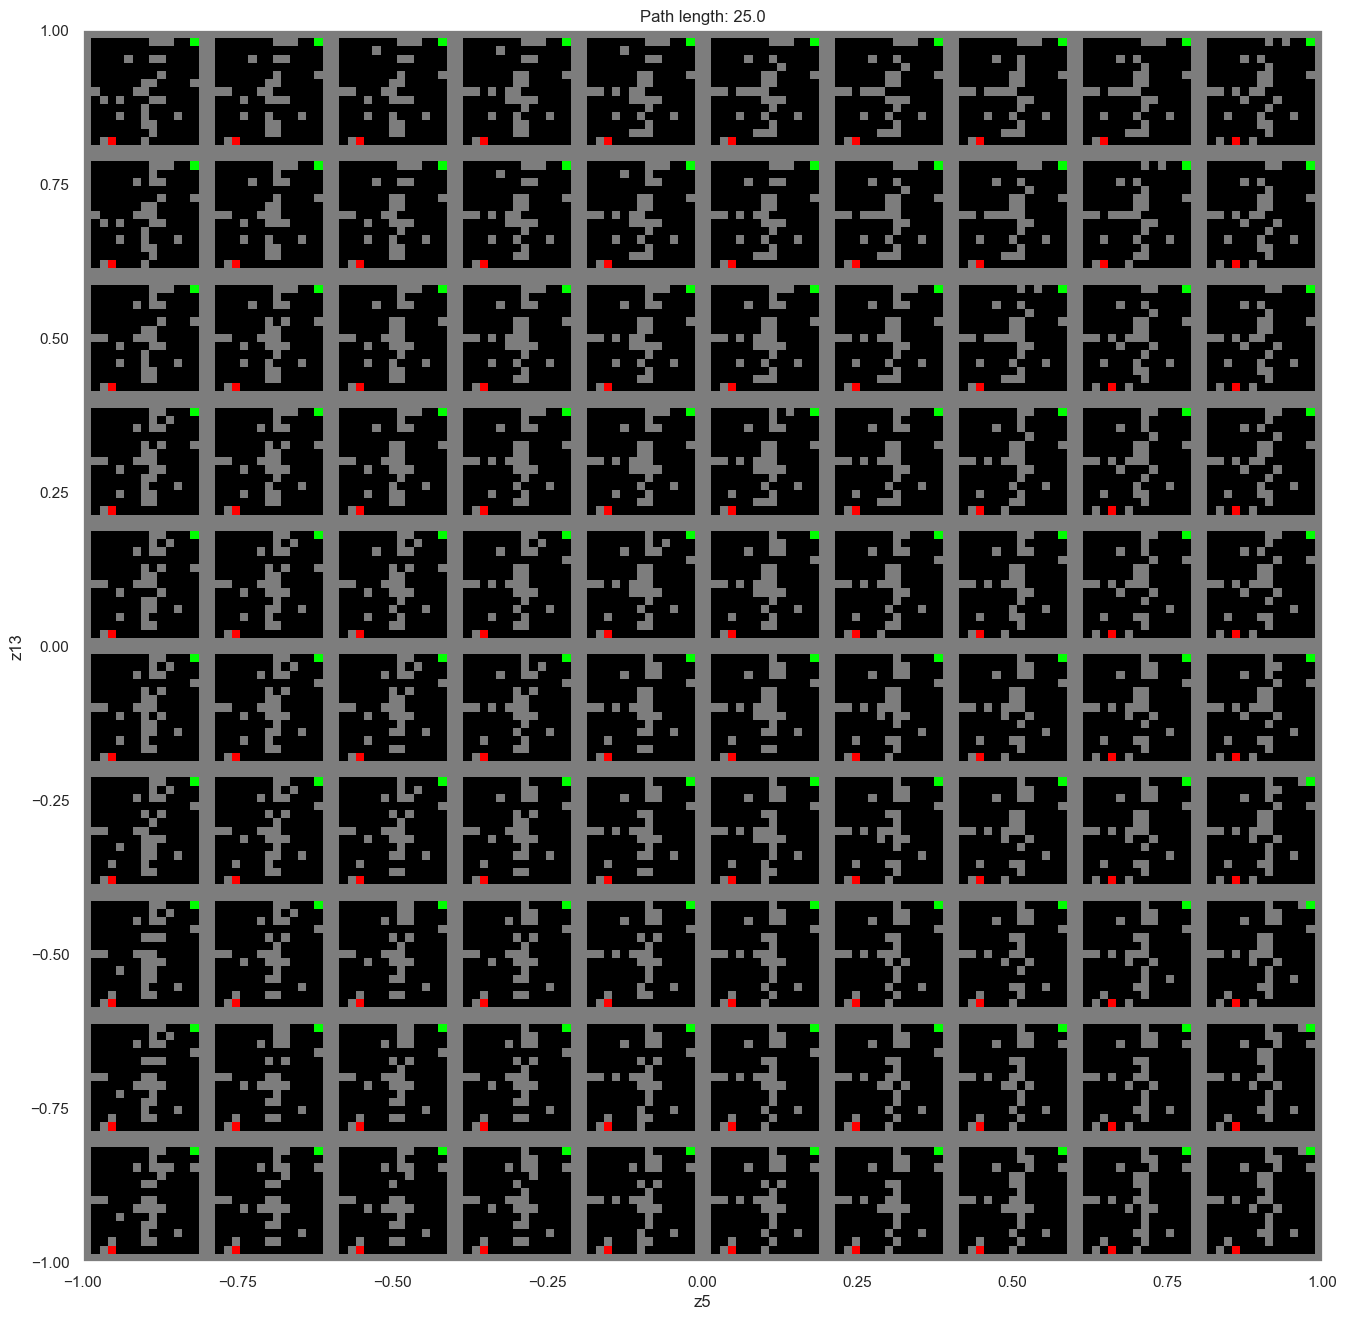

In [71]:
# Generate vector with random values
z_ = np.random.rand(1, latent_dim)

# Shortest path length
path_length_ = 25
path_length_ = torch.tensor([path_length_]).to(device).float()

# Number of grids to plot in each dimension
n = 10

# Latent variables to vary
c0, c1 = np.random.choice(latent_dim, 2, replace=False)

# Limits
r0 = (-1, 1)
r1 = (-1, 1)

img_size = (15, 15)
w = img_size[0]
img = np.zeros((n*w, n*w,3)).astype(np.uint8)

plt.figure(figsize=(16,16))
# Variate the first element of the vector
for i, x in enumerate(np.linspace(*r0, n)):
    for j, y in enumerate(np.linspace(*r1, n)):
        z = z_.copy()
        z[0,c0] = x
        z[0,c1] = y
        z = torch.tensor(z).to(device).ravel().float()
        z = torch.cat([z, path_length_], dim=-1)
        recon_x = vae_model.decoder(z)
        # Reconstruct image using VAE
        recon_x = recon_x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
        grid_img = generate_grid_image(recon_x)
        
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w, :] = grid_img.astype(np.uint8)

plt.imshow(img, extent=[*r1, *r0], aspect="auto")
plt.grid(False)
plt.xlabel(f"z{c1}")
plt.ylabel(f"z{c0}")
plt.title(f"Path length: {path_length_.item()}")
plt.show()

In [30]:
# Generate easy grid and hard grid
easy = 3
hard = 25

# Interpolate between easy and hard grid
n = 1000
z_ = np.random.rand(n, latent_dim+1)
z_[:, -1] = np.linspace(easy, hard, n)

grids = []
for i in range(n):
    z = torch.tensor(z_[i]).to(device).ravel().float()
    recon_x = vae_model.decoder(z)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
    grid_img = generate_grid_image(recon_x)
    grids.append(grid_img)

In [31]:
import imageio
# Create a gif from the images
imageio.mimsave(f'vae_{latent_dim}_latent_space.gif', grids, duration=200, format="GIF")

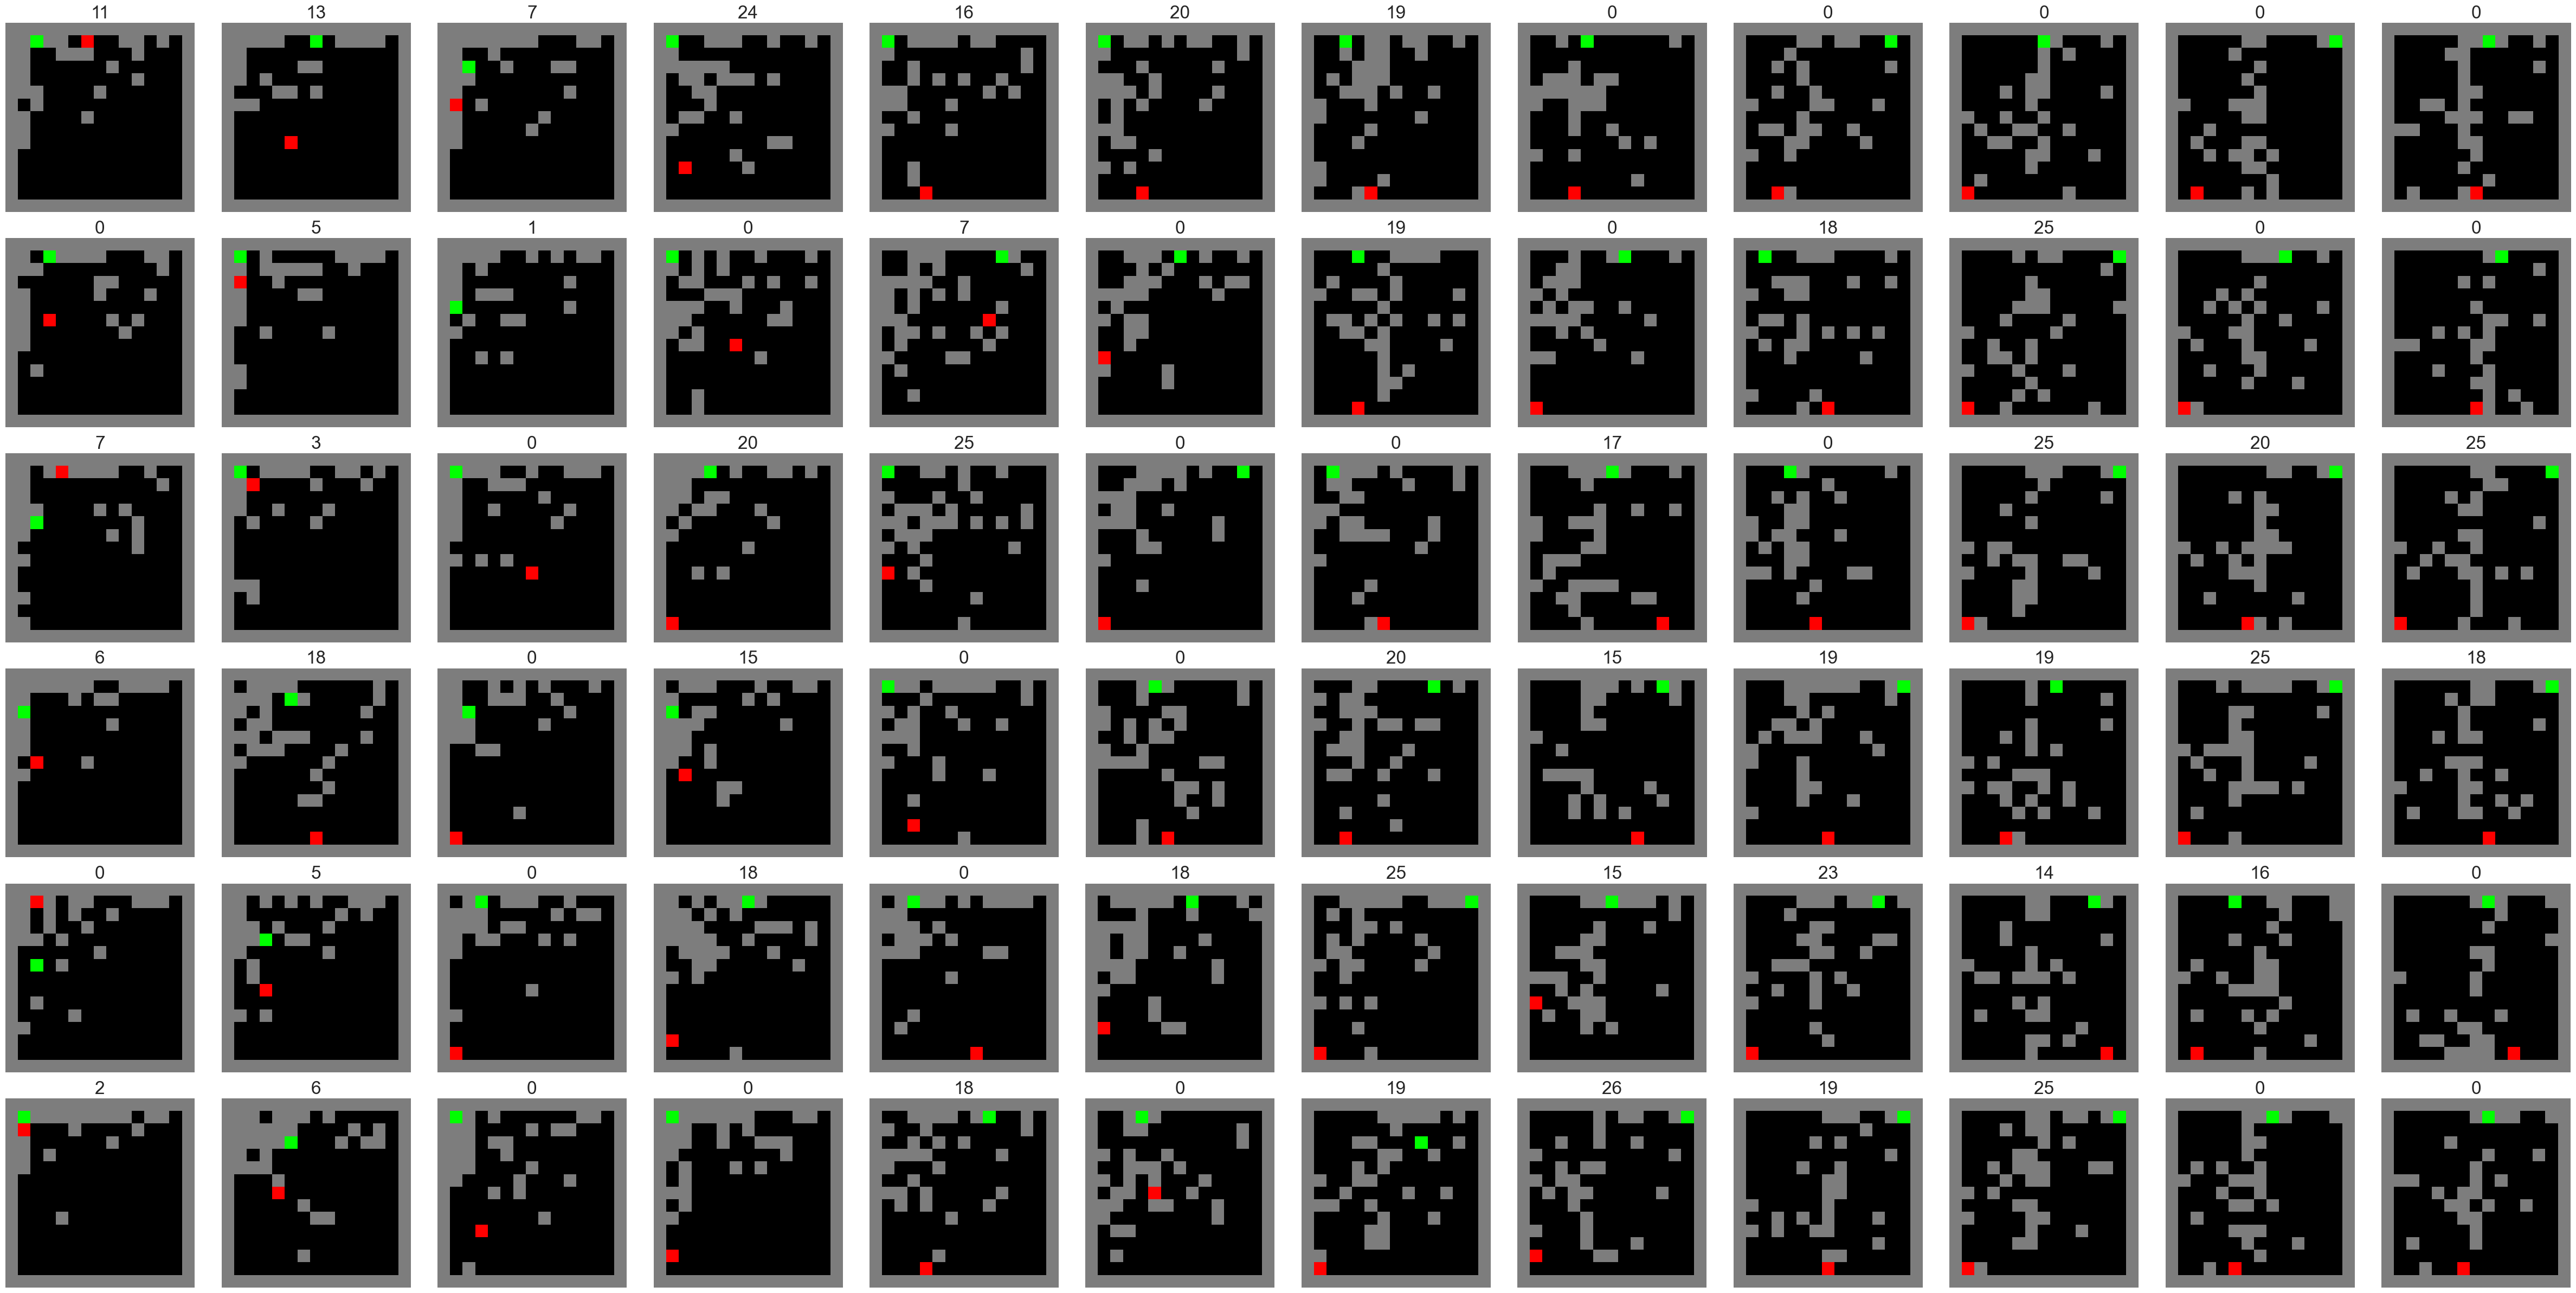

In [86]:
# Plot grids with increasing shortest path length
n_path_lengths = 11
min_path_length, max_path_length = 2, 25
path_lengths = range(min_path_length, max_path_length, (max_path_length-min_path_length)//(n_path_lengths-1))
n_grids = 6
img_size = (15, 15)
w, h = img_size[0], img_size[1]

plt.figure(figsize=(4*len(path_lengths), 4*n_grids))

path_lengths_ = [[] for _ in range(n_grids)]

for i in range(n_grids):
    for j, c in enumerate(path_lengths):
        z = np.random.uniform(-2, 2, (1, latent_dim))
        z = np.append(z, c)
        z = torch.tensor(z).to(device).ravel().float()
        # Reconstruct image using VAE
        recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
        plt.subplot(n_grids, len(path_lengths), i*len(path_lengths)+j+1)
        grid_img = generate_grid_image(recon_x)
        grid_img_ = generate_grid_image(recon_x, start_goal=False)

        maze = np.ceil(grid_img_/255).mean(axis=-1).astype(int)
        positions = recon_x[-2:].ravel() + 1  # Add 1 to account for outer walls

        path = get_shortest_path(maze, positions)
        path_length_ = len(path)

        path_lengths_[i].append(path_length_)

        plt.imshow(grid_img)
        plt.grid(False)
        plt.axis('off')
        plt.title(f"{path_length_}", fontsize=24)

plt.tight_layout()

(0.0, 25.0)

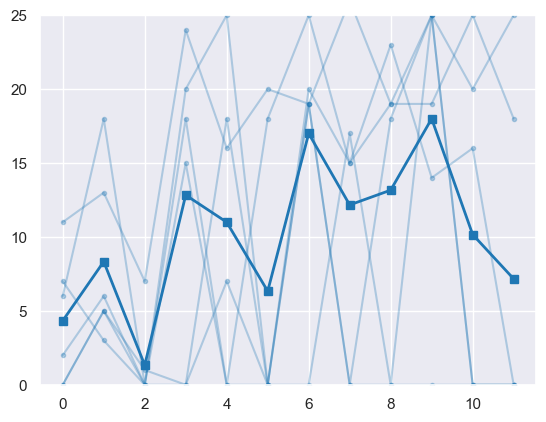

In [88]:
path_lengths_mean = np.mean(path_lengths_, axis=0)

for i in range(n_grids):
    plt.plot(path_lengths_[i], marker=".", color="tab:blue", alpha=0.3)

plt.plot(path_lengths_mean, marker="s", color="tab:blue", linewidth=2)
plt.ylim(0,25)

Path length: 13


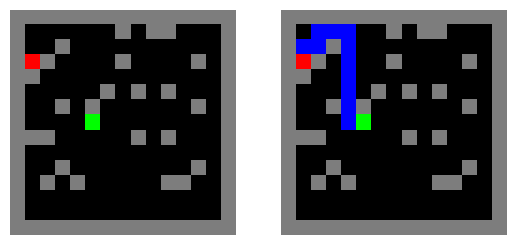

In [168]:
plt.subplot(121)
plt.imshow(grid_img_zero)
plt.grid(False)
plt.axis('off')

plt.subplot(122)
maze = np.copy(grid_img_zero)
path_zero = get_shortest_path(maze_zero, positions_zero)
# Replace path
for p in path_zero[1:-1]:
    p = (p.x, p.y)
    maze[p[1], p[0]] = [0, 0, 255]

plt.imshow(maze)
plt.grid(False)
plt.axis('off')

print("Path length:", len(path_zero))

In [134]:
import scipy.stats as stats

Difficulty: 16
Difficulty: 22
Difficulty: 22
Difficulty: 24
Difficulty: 14
Difficulty: 24
Difficulty: 23
Difficulty: 24
Difficulty: 18
Difficulty: 11
Difficulty: 17
Difficulty: 19
Difficulty: 24
Difficulty: 21
Difficulty: 5
Difficulty: 23


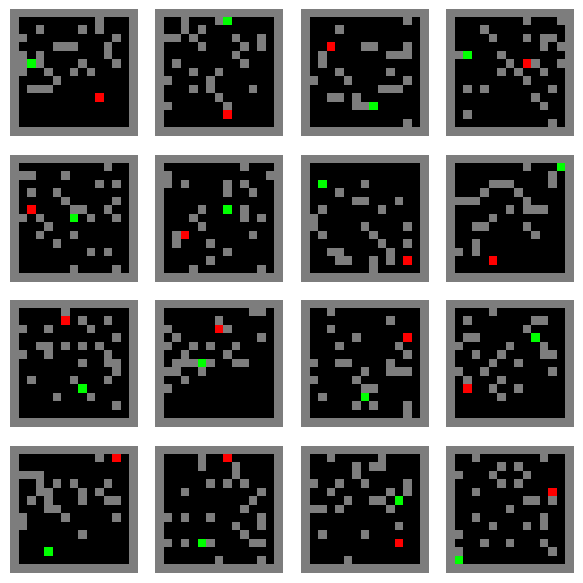

In [138]:
min_difficulty = 2
max_difficulty = 25
difficulties = np.arange(min_difficulty, max_difficulty, 1)

difficulty = 25

weights = stats.norm.pdf(difficulties, difficulty, 2.5)
weights += (1 - weights.sum())/weights.shape[0]  # Make sum to 1

# Plot several grids

n = 16

plt.figure(figsize=(6,6))

for i in range(n):
    d = np.random.choice(difficulties, p=weights)
    z = np.random.uniform(-2, 2, (1, latent_dim))
    z = np.append(z, d)
    z = torch.tensor(z).to(device).ravel().float()
    # Reconstruct image using VAE
    recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
    plt.subplot(4,4,i+1)
    grid_img = generate_grid_image(recon_x)
    plt.imshow(grid_img)
    plt.grid(False)
    plt.axis('off')
    print("Difficulty:", d)

plt.tight_layout()